In [6]:
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

In [7]:
import numpy as np
import pdb

# my code
from distribution import PolynomialSigmoidBernoulli, GaussianNoise
from gaussian_mixture_analytic_expectations import *
from fully_observed_models import SumOfTwoUnnormalisedGaussians
from latent_variable_model import MixtureOfTwoUnnormalisedGaussians
from nce_optimiser import NCEOptimiser
from utils import mean_square_error
from vnce_optimisers import VNCEOptimiserWithAnalyticExpectations, VNCEOptimiser

from itertools import product
from matplotlib import pyplot as plt
from matplotlib import rc
from numpy import random as rnd

%matplotlib inline
rc('lines', linewidth=3)
rc('font', size=18)
rc('legend', fontsize=18)

DEFAULT_SEED = 1083463236
rng = rnd.RandomState(DEFAULT_SEED)

In [8]:
# E(r(x, z))
E1 = E_r
# E(log(psi_1(x, z)))
E2 = E_log_psi_1
# E((psi_1(x, z) - 1) / psi_1(x, z))
E3 = E_psi_1_ratio_times_grad_log_theta
# E(grad_theta(log(phi(u,z)) r(u, z))
E4 = E_r_times_grad_log_theta
# gradient_alpha(E(log(psi_1(x, z)))
E5 = grad_wrt_alpha_of_E_log_psi_1

In [4]:
# mixing proportions: 0.5 and 0.5
# mean0 = mean1 = 0
sigma1 = 4.7
nz = 1  # number of latent samples per datapoint
nu = 1 # nu is the ratio of noise to data samples in NCE

# number of data points
n = 20000

# number of random inits of data and theta
num_random_initialisations = 100

In [5]:
model = MixtureOfTwoUnnormalisedGaussians(np.array([0, 0]), sigma1=sigma1)
no_latent_var_model = SumOfTwoUnnormalisedGaussians(np.array([0, 0]), sigma1=sigma1)  # for comparison
var_dist = PolynomialSigmoidBernoulli(alpha=np.array([0,0,0]))

In [6]:
sigma0_vals = np.arange(1, 10, 0.5)
n_sigma0_vals = len(sigma0_vals)

true_thetas = np.zeros((n_sigma0_vals, 2))
nce_theta_estimates = np.zeros((n_sigma0_vals, num_random_initialisations, 2))
latent_nce_theta_estimates = np.zeros((n_sigma0_vals, num_random_initialisations, 2))

The following should take (up to) 20 hours:

In [7]:
for i in range(n_sigma0_vals):
    for j in range(num_random_initialisations):
        
        # true value of parameters
        sigma0 = sigma0_vals[i]
        true_c = 0.5*np.log(2*np.pi) + np.log(sigma1 + sigma0) 
        true_theta = np.array([true_c, np.log(sigma0)])
        true_thetas[i] = true_theta

        # random initial values for optimisation
        theta0 = np.array([0, np.log(rnd.uniform(1, 9))])
        alpha0 = np.array([0, 0, 0])

        # generate data
        true_data_dist = MixtureOfTwoUnnormalisedGaussians(theta=true_theta, sigma1=sigma1)
        X = true_data_dist.sample(n)

        # noise dist
        noise = GaussianNoise(mean=0, std = sigma0)
        Y = noise.sample(int(n*nu))

        nce_optimiser = NCEOptimiser(no_latent_var_model, noise, n, nu=nu, eps = 10**-20)
        optimiser = LatentNCEOptimiserWithAnalyticExpectations(model, noise, var_dist, n,
                                                           E1, E2, E3, E4, E5, 
                                                           nu=nu, latent_samples_per_datapoint=nz, eps = 10**-20)
        nce_optimiser.fit(X, theta0=theta0, disp=False, plot=False)
        nce_theta_estimates[i, j] = no_latent_var_model.theta
        
        optimiser.fit(X, theta0=theta0, alpha0=alpha0, disp=False, plot=False)
        latent_nce_theta_estimates[i, j] = model.theta

/afs/inf.ed.ac.uk/user/s17/s1771906/masters-project/ben-rhodes-masters-project/proposal/code/distribution.py:98: RuntimeWarning: overflow encountered in exp
  return 1/(1 + np.exp(-u))


In [8]:
nce_mses = []
latent_nce_mses = []
for i in range(n_sigma0_vals):
    nce_mses.append(mean_square_error(nce_theta_estimates[i, :, :], true_thetas[i], plot=False))
    latent_nce_mses.append(mean_square_error(latent_nce_theta_estimates[i, :, :], true_thetas[i], plot=False))

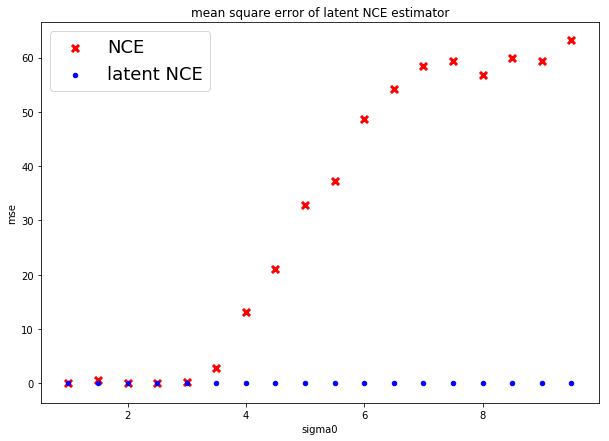

In [9]:
fig, ax = plt.subplots(1,1, figsize=(10,7))
ax.scatter(sigma0_vals, nce_mses, marker='x', color='r', label='NCE', s=50)
ax.scatter(sigma0_vals, latent_nce_mses, marker='o', color='b', label='latent NCE', s=20)
ax.set_title('mean square error of latent NCE estimator')
ax.set_xlabel('sigma0')
ax.set_ylabel('mse')
_ = ax.legend(loc='best')

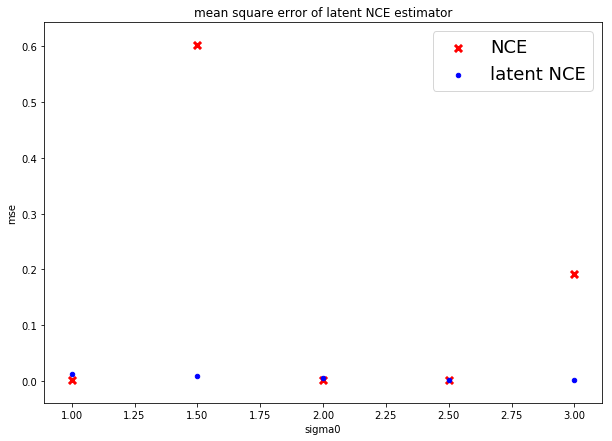

In [10]:
fig, ax = plt.subplots(1,1, figsize=(10,7))
ax.scatter(sigma0_vals[:5], nce_mses[:5], marker='x', color='r', label='NCE', s=50)
ax.scatter(sigma0_vals[:5], latent_nce_mses[:5], marker='o', color='b', label='latent NCE', s=20)
ax.set_title('mean square error of latent NCE estimator')
ax.set_xlabel('sigma0')
ax.set_ylabel('mse')
_ = ax.legend(loc='best')